## Import necessary packages

In [1]:
# Add ../../ to path
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

In [2]:
import sys

from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

from cyclum import writer
from scPPR.periodic_inference import PeriodicInference
from scPPR.stage_classifier import StageClassifier
from scPPR.plot import plot_inference

## Read data

In [3]:
input_file_mask = '../data/mESC/mesc-tpm'

def preprocess(input_file_mask):
    """
    Read in data and perform log transform (log2(x+1)), centering (mean = 1) and scaling (sd = 1).
    """
    tpm = writer.read_df_from_binary(input_file_mask).T
    sttpm = np.log2(tpm + 1)
    
    label = pd.read_csv(input_file_mask + '-label.txt', sep="\t", index_col=0).T
    return sttpm, label

sttpm, label = preprocess(input_file_mask)
gene_df = sttpm.join(label).set_index('stage').T
gene_df = gene_df[gene_df.T.var() != 0]

## SVD

In [4]:
def eigenexpression_fraction(sigma):
    sigma_power = np.power(sigma, 2)
    return sigma_power / np.sum(sigma_power)

def shannon_entropy(exp_fraction):
    return -1 / np.log(len(exp_fraction)) * np.sum(exp_fraction * np.log(exp_fraction))

U, sigma, VT = np.linalg.svd(gene_df, full_matrices=False)
exp_fraction = eigenexpression_fraction(sigma)
entropy = shannon_entropy(exp_fraction)
print(exp_fraction[:30], entropy)

[0.78858293 0.00586521 0.00315919 0.00243922 0.00186902 0.00166415
 0.00150043 0.00134821 0.00127559 0.00119912 0.00117039 0.00110846
 0.0010897  0.00107583 0.00105753 0.00103978 0.00103739 0.00102671
 0.0010229  0.0010178  0.00101048 0.00099982 0.00099174 0.00098765
 0.00098092 0.0009777  0.00097492 0.00097225 0.00096834 0.00095833] 0.2989204602002367


In [5]:
# choose eigngene1,..., eigngene4
V = VT.T
V_scaled = preprocessing.scale(V)

data = V_scaled[:, 1:5]
N = 500
per_inf = PeriodicInference(N, N_iterations_MCMC = int(1e4), N_passes_optimisation=0)

ml_phases, ml_likelihood, samples_phase, samples_likelihood = per_inf.estimate_uncertainty(data)
# import pickle
# with open('../data/mESC_eign4.pickle', 'rb') as pickle_file:
#     save_variables = pickle.load(pickle_file)
#     ml_phases = save_variables["ml_phases"]
#     samples_phase = save_variables["samples_phase"]
#     ml_likelihood = save_variables["ml_likelihood"]
#     samples_likelihood = save_variables["samples_likeilhood"]

print(ml_phases[:,0])

individual_phases = per_inf.predict_phases(data, ml_phases[:,0])

phase_init:  [0.         5.22761018 2.33734493 2.45044227]
Optimise mcmc settings
phase_sigma_opt:  1.0
Run mcmc
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iteration 3000 of 10000 , 30 % complete
Iteration 4000 of 10000 , 40 % complete
Iteration 5000 of 10000 , 50 % complete
Iteration 6000 of 10000 , 60 % complete
Iteration 7000 of 10000 , 70 % complete
Iteration 8000 of 10000 , 80 % complete
Iteration 9000 of 10000 , 90 % complete
Accept Ratio: 0.4852
[0.         1.5833627  5.18991106 0.06283185]


## Plot

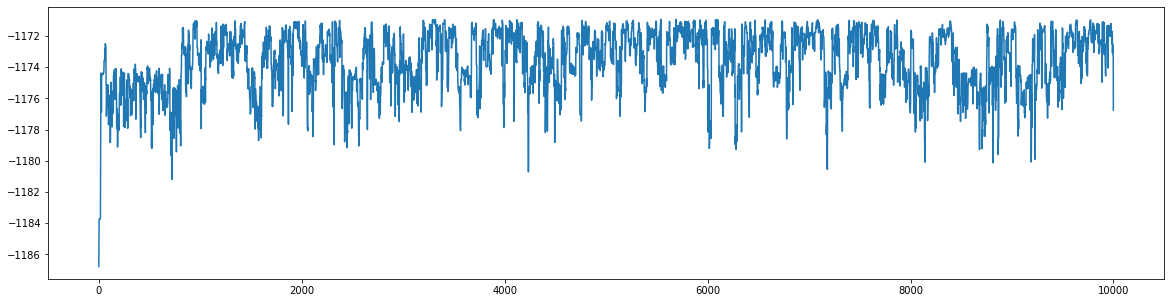

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(samples_likelihood)), samples_likelihood)
plt.show()

In [7]:
samples_likelihood

array([[-1186.77709325],
       [-1185.3389905 ],
       [-1185.3389905 ],
       ...,
       [-1173.24898128],
       [-1173.24898128],
       [-1176.75151537]])

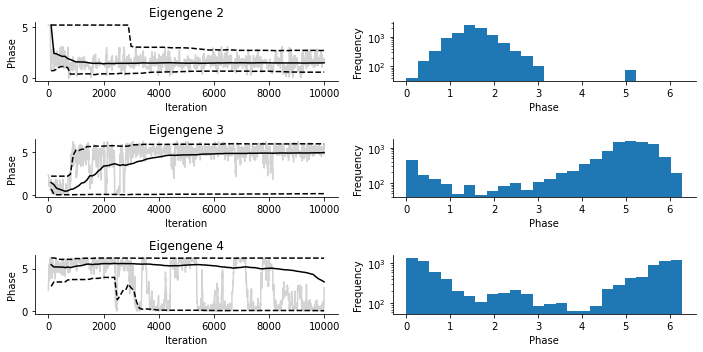

In [8]:
plot_inference(samples_phase)

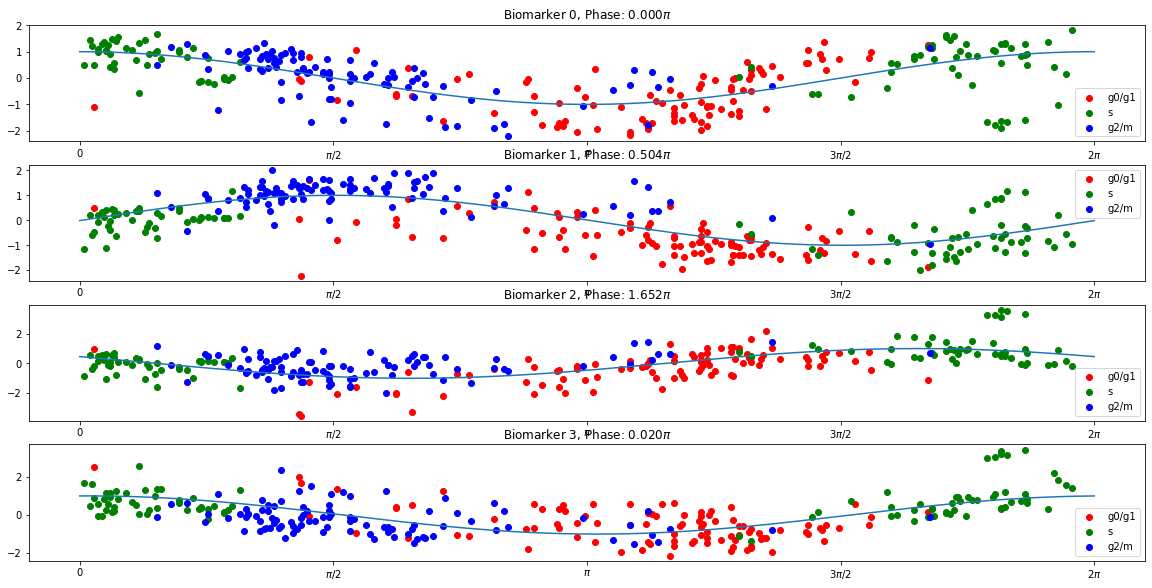

In [9]:
n_biomarkers = 6
plt.figure(figsize=(20, 15))
bins = np.linspace(0, 2 * np.pi, 1000)
tick_bins = np.linspace(0, 2 * np.pi, 5)
ticks = ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2', r'2$\pi$']
color_map = {'stage': {"g0/g1": "red", "s": "green", "g2/m": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}

for i, phase in enumerate(ml_phases[:,0]):
    gt = np.cos(bins - phase)
    plt.subplot(n_biomarkers, 1, i+1)
    plt.plot(bins, gt)
    for l, c in color_map['stage'].items():
        index = gene_df.columns == l
        plt.scatter(individual_phases[index], data[index][:,i], label=l, color=c)
    plt.title('Biomarker {}, Phase: {:.3f}$\pi$'.format(i, phase/np.pi))
    plt.xticks(tick_bins, ticks, rotation=0)
    plt.tick_params(labelsize=10)
    plt.legend(loc='best')
plt.show()

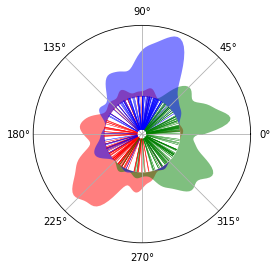

In [10]:
import cyclum.illustration
cyclum.illustration.plot_round_distr_color(individual_phases, gene_df.columns, color_map['stage'])
pass